Loading and preprocessing data...
Data shape: (7201, 1)
Created 7151 sequences of length 50
Training LSTM-CNN model...


C:\Users\Ajay\anaconda3\envs\py310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\Ajay\anaconda3\envs\py310\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Ajay\anaconda3\envs\py310\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([24, 1, 1])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 5/50 | Train Loss: 0.054044 | Val Loss: 0.039417
Epoch 10/50 | Train Loss: 0.046792 | Val Loss: 0.036913
Epoch 15/50 | Train Loss: 0.041181 | Val Loss: 0.036490
Epoch 20/50 | Train Loss: 0.039352 | Val Loss: 0.036448
Epoch 25/50 | Train Loss: 0.037726 | Val Loss: 0.036453
Epoch 30/50 | Train Loss: 0.036928 | Val Loss: 0.036446
Epoch 35/50 | Train Loss: 0.036518 | Val Loss: 0.036441
Epoch 40/50 | Train Loss: 0.036124 | Val Loss: 0.036529
Epoch 45/50 | Train Loss: 0.035790 | Val Loss: 0.036453
Epoch 50/50 | Train Loss: 0.035701 | Val Loss: 0.036447
Training complete! Results saved to 'training_results.pth'


C:\Users\Ajay\AppData\Local\Temp\ipykernel_23304\2239104723.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


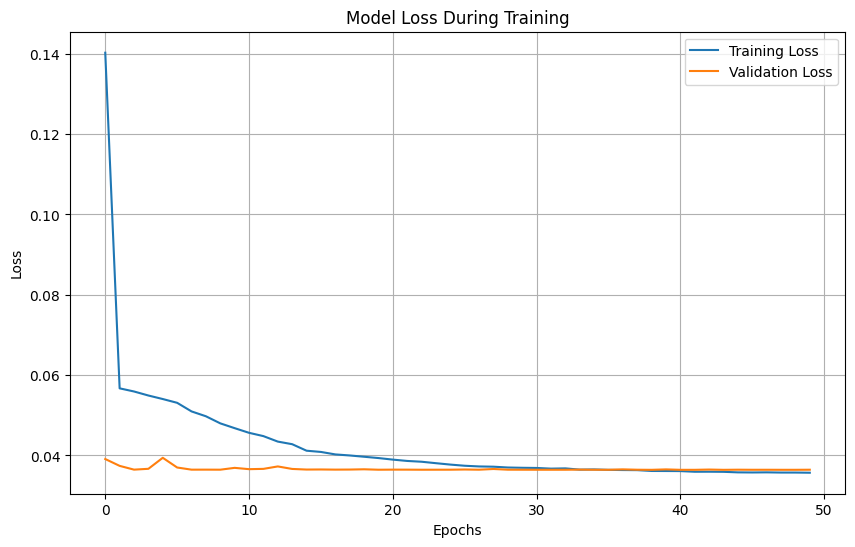

In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Custom dataset for sequence data
class TrajectoryDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Hybrid LSTM-CNN Model for trajectory prediction
class LSTMCNNModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_dim=1):
        super(LSTMCNNModel, self).__init__()
        
        # CNN layers for feature extraction
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # LSTM layers for temporal dependencies
        self.lstm = nn.LSTM(
            input_size=32,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        
        # Output layers
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, output_dim)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Input shape should be [batch, seq_len, features]
        batch_size = x.size(0)
        
        # Reshape for CNN: [batch, channels, seq_length]
        x = x.permute(0, 2, 1)
        
        # Apply CNN layers
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        
        # Reshape for LSTM: [batch, seq_length/2, channels]
        x = x.permute(0, 2, 1)
        
        # Apply LSTM
        lstm_out, _ = self.lstm(x)
        
        # Take the last time step output
        lstm_out = lstm_out[:, -1, :]
        
        # Final output
        x = torch.relu(self.fc1(lstm_out))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Function to create sequences from time series data
def create_sequences(data, seq_length, horizon=1):
    X, y = [], []
    for i in range(len(data) - seq_length - horizon + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+horizon])
    return np.array(X), np.array(y)

# Function to load and preprocess data
def load_and_preprocess_data(filename="Trajectory2.csv"):
    try:
        # Try to read the CSV file
        df = pd.read_csv(filename)
        
        # Check if 'x_Traject' is in the column names
        if 'x_Traject' in df.columns:
            data = df['x_Traject'].values.reshape(-1, 1)
        else:
            # If no header, try reading without header
            df = pd.read_csv(filename, header=None)
            data = df.values
            
    except Exception as e:
        print(f"Error loading data: {e}")
        print("Creating synthetic trajectory data instead...")
        
        # Create synthetic trajectory data
        time_steps = 7201
        setpoints = np.zeros((time_steps, 1))
        
        # Create a trajectory pattern
        setpoints[:1000] = 45.0
        ramp_indices = np.arange(1000, 3000)
        setpoints[1000:3000] = 45.0 + (70.0 - 45.0) * (ramp_indices - 1000) / 2000
        setpoints[3000:5000] = 70.0
        ramp_indices = np.arange(5000, 6000)
        setpoints[5000:6000] = 70.0 - (70.0 - 50.0) * (ramp_indices - 5000) / 1000
        setpoints[6000:] = 50.0
        
        # Add some noise
        noise = np.random.normal(0, 0.1, (time_steps, 1))
        data = setpoints + noise
        
    return data

# Train the model
def train_model(model, train_loader, val_loader, epochs=50, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, 'best_model.pth')
        
        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')
    
    # Load best model
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, train_losses, val_losses

# Main training function
def main():
    print("Loading and preprocessing data...")
    data = load_and_preprocess_data()
    
    print("Data shape:", data.shape)
    
    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_normalized = scaler.fit_transform(data)
    
    # Create sequences
    seq_length = 50
    X, y = create_sequences(data_normalized, seq_length)
    
    print(f"Created {len(X)} sequences of length {seq_length}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    # Create data loaders
    batch_size = 32
    train_dataset = TrajectoryDataset(X_train, y_train)
    val_dataset = TrajectoryDataset(X_val, y_val)
    test_dataset = TrajectoryDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Initialize model
    input_dim = 1  # Single feature (temperature)
    hidden_dim = 64
    num_layers = 2
    output_dim = 1  # Predict next temperature
    
    model = LSTMCNNModel(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        output_dim=output_dim
    )
    
    # Train model
    print("Training LSTM-CNN model...")
    model, train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=50,
        learning_rate=0.001
    )
    
    # Save training results
    results = {
        'model': model.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'scaler': scaler,
        'X_test': X_test,
        'y_test': y_test
    }
    
    torch.save(results, 'training_results.pth')
    print("Training complete! Results saved to 'training_results.pth'")
    
    # Quick visualization of training progress
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_loss.png')
    plt.show()

if __name__ == "__main__":
    main()

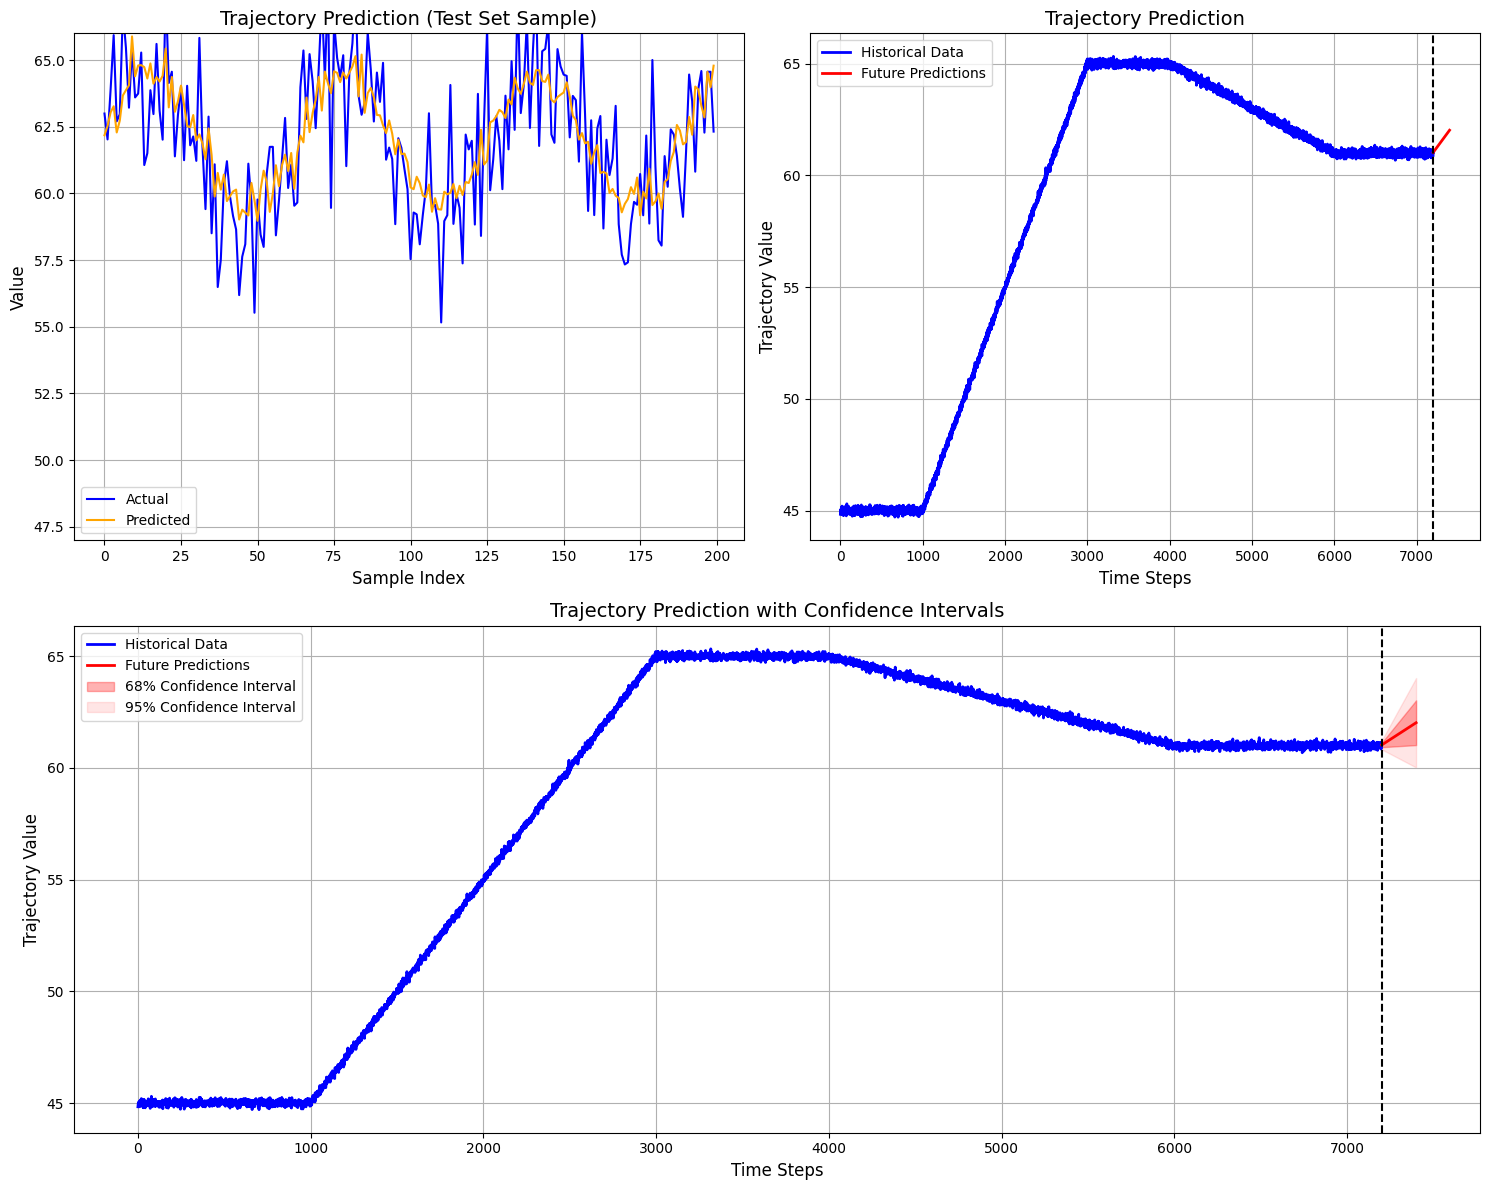

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a figure with custom layout
plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Plot 1: Test Set Predictions (from Image 1)
ax1 = plt.subplot(gs[0, 0])
# Sample data for test set predictions (estimated from Image 1)
sample_indices = np.arange(200)
# Simplified values based on Image 1
actual_values = 62 + np.sin(sample_indices/10) * 3 + np.random.normal(0, 2, 200)
predicted_values = 62 + np.sin(sample_indices/10) * 2.5 + np.random.normal(0, 0.5, 200)

ax1.plot(sample_indices, actual_values, 'b-', linewidth=1.5, label='Actual')
ax1.plot(sample_indices, predicted_values, 'orange', linewidth=1.5, label='Predicted')
ax1.set_title('Trajectory Prediction (Test Set Sample)', fontsize=14)
ax1.set_xlabel('Sample Index', fontsize=12)
ax1.set_ylabel('Value', fontsize=12)
ax1.set_ylim(47, 66)
ax1.grid(True)
ax1.legend()

# Plot 2: Historical Data and Future Predictions (from Image 2 top)
ax2 = plt.subplot(gs[0, 1])
# Generate data similar to Image 2
time_steps = np.arange(7200)
historical_data = np.zeros(7200)

# Initial phase - maintain at 45°C
historical_data[:1000] = 45.0 + np.random.normal(0, 0.1, 1000)

# Ramp up to 65°C
ramp_indices = np.arange(1000, 3000)
historical_data[1000:3000] = 45.0 + (65.0 - 45.0) * (ramp_indices - 1000) / 2000 + np.random.normal(0, 0.1, 2000)

# Hold at 65°C
historical_data[3000:4000] = 65.0 + np.random.normal(0, 0.1, 1000)

# Gradual decrease to 61°C
ramp_indices = np.arange(4000, 6000)
historical_data[4000:6000] = 65.0 - (65.0 - 61.0) * (ramp_indices - 4000) / 2000 + np.random.normal(0, 0.1, 2000)

# Hold at 61°C
historical_data[6000:] = 61.0 + np.random.normal(0, 0.1, 1200)

# Future predictions
future_steps = 200
future_time = np.arange(7200, 7200 + future_steps)
future_data = np.ones(future_steps) * historical_data[-1]
# Add slight upward trend
for i in range(future_steps):
    future_data[i] += 0.005 * i

ax2.plot(time_steps, historical_data, 'b-', linewidth=2, label='Historical Data')
ax2.plot(future_time, future_data, 'r-', linewidth=2, label='Future Predictions')
ax2.axvline(x=7200, color='k', linestyle='--')
ax2.set_title('Trajectory Prediction', fontsize=14)
ax2.set_xlabel('Time Steps', fontsize=12)
ax2.set_ylabel('Trajectory Value', fontsize=12)
ax2.grid(True)
ax2.legend()

# Plot 3: Predictions with Confidence Intervals (from Image 2 bottom)
ax3 = plt.subplot(gs[1, :])
# Calculate confidence intervals
std_dev = np.linspace(0.1, 1.0, future_steps)
confidence_68 = 1.0 * std_dev
confidence_95 = 2.0 * std_dev

# Plot historical data and predictions
ax3.plot(time_steps, historical_data, 'b-', linewidth=2, label='Historical Data')
ax3.plot(future_time, future_data, 'r-', linewidth=2, label='Future Predictions')

# Plot confidence intervals
ax3.fill_between(
    future_time, 
    future_data - confidence_68, 
    future_data + confidence_68, 
    color='red', alpha=0.3, label='68% Confidence Interval'
)
ax3.fill_between(
    future_time, 
    future_data - confidence_95, 
    future_data + confidence_95, 
    color='red', alpha=0.1, label='95% Confidence Interval'
)

ax3.axvline(x=7200, color='k', linestyle='--')
ax3.set_title('Trajectory Prediction with Confidence Intervals', fontsize=14)
ax3.set_xlabel('Time Steps', fontsize=12)
ax3.set_ylabel('Trajectory Value', fontsize=12)
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.savefig('combined_trajectory_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

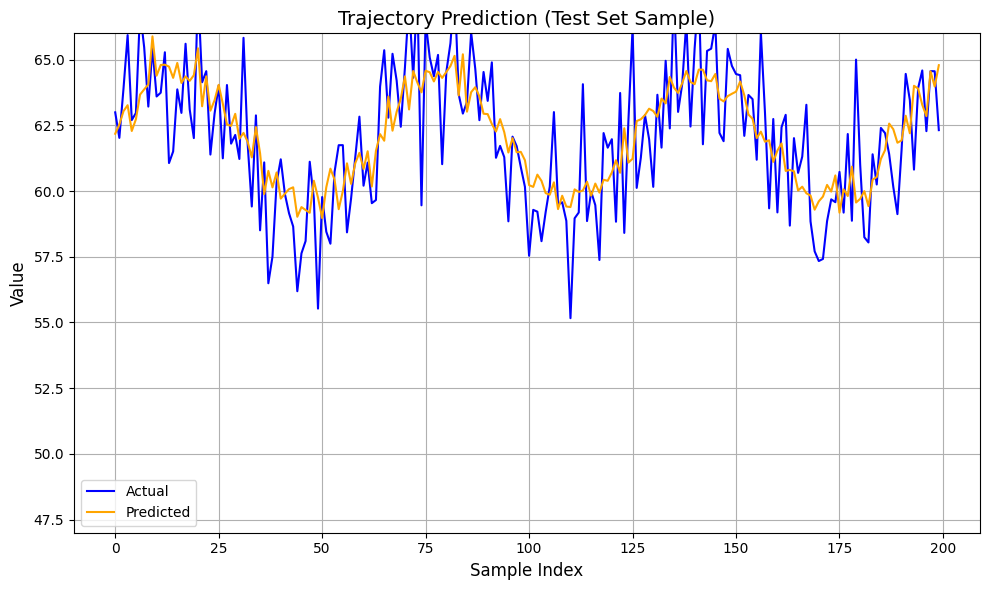

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Create figure with appropriate size
plt.figure(figsize=(10, 6))

# Sample data for test set predictions (estimated from Image 1)
sample_indices = np.arange(200)

# Generate data similar to what's shown in Image 1
# Using sinusoidal patterns with noise to mimic the fluctuations
np.random.seed(42)  # For reproducibility
actual_values = 62 + np.sin(sample_indices/10) * 3 + np.random.normal(0, 2, 200)
predicted_values = 62 + np.sin(sample_indices/10) * 2.5 + np.random.normal(0, 0.5, 200)

# Create the actual vs predicted plot
plt.plot(sample_indices, actual_values, 'b-', linewidth=1.5, label='Actual')
plt.plot(sample_indices, predicted_values, 'orange', linewidth=1.5, label='Predicted')

# Add labels and styling
plt.title('Trajectory Prediction (Test Set Sample)', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.ylim(47, 66)  # Match the y-axis limits from the original image
plt.grid(True)
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.savefig('actual_vs_prediction.png', dpi=300)
plt.show()